In [60]:
%matplotlib inline

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
from statistics import mean
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [61]:
echo_genres = pd.read_csv('//Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


## Binary Classification Rock - Hip-Pop

In [62]:
rock_pop = echo_genres[echo_genres['genre_top'].isin(['Hip-Hop','Rock'])]
rock_pop.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [63]:
# check shape
rock_pop.shape

(4802, 9)

In [64]:
rock_pop.genre_top.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

In [65]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
rock_pop['genre_top'] = le.fit_transform(rock_pop['genre_top'])

In [66]:
print('legend:\n0: Hip-Hop\n1: Rock')
rock_pop.genre_top.value_counts()

legend:
0: Hip-Hop
1: Rock


1    3892
0     910
Name: genre_top, dtype: int64

In [67]:
genre_labels = rock_pop['genre_top']
rock_pop.drop('genre_top', axis=1, inplace=True)

In [68]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
rock_pop, genre_labels, test_size=0.30, random_state=42)

In [73]:
# check partition
print(f"____Legend____\n1: Rock\n0: Hip-Hop\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
1: Rock
0: Hip-Hop

Development set:
1    2723
0     638
Name: genre_top, dtype: int64

Internal Test:
1    1169
0     272
Name: genre_top, dtype: int64


In [70]:
# normalize data
scaler = StandardScaler(copy=False)
X_develop = scaler.fit_transform(X_develop)
X_test = scaler.transform(X_test)

# PCA - Rock Hip-Hop

In [71]:
# 2D PCA
pca = PCA(n_components=2)
pca.fit(X_develop)
X_pca = pca.transform(X_develop)

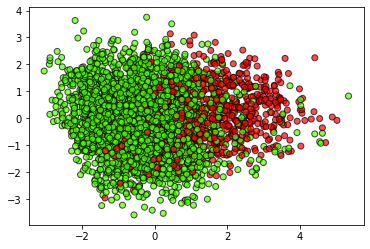

In [72]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_develop, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Model selection

In [75]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [77]:
# 10 fold cross validation - grid search
param_grid = {
               "max_depth": [3,4,5,6, None],
               "min_samples_leaf": [25,45,75,150,250,300,400,500,600],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Model with rank: 1
Mean validation score: 0.894 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.892 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.892 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.892 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 45}

Model with rank: 5
Mean validation score: 0.891 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 6
Mean validation score: 0.891 (std: 0.014)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 25}

Model with rank: 7
Mean validation score: 0.891 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth'

## Retrain on full development set and prediction

Accuracy 0.9070090215128384
F1-score [0.7372549  0.94350759]
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       272
           1       0.93      0.96      0.94      1169

    accuracy                           0.91      1441
   macro avg       0.86      0.82      0.84      1441
weighted avg       0.90      0.91      0.90      1441



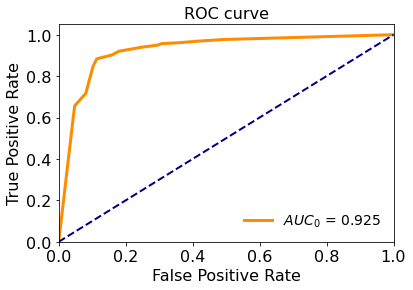

In [78]:
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=4, min_samples_leaf= 45)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

y_score = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()